## 0. Simulate some data and fit an emulator

In [1]:
import torch

from autoemulate.experimental.simulations.projectile import ProjectileMultioutput
from autoemulate.experimental.emulators.gaussian_process.exact import (
    GaussianProcessExact,
)

In [2]:
sim = ProjectileMultioutput()
x = sim.sample_inputs(100)
y = sim.forward_batch(x)

Running simulations: 100%|██████████| 100/100 [00:00<00:00, 1206.37it/s]

Successfully completed 100/100 simulations (100.0%)


In [3]:
gp = GaussianProcessExact(x, y)
gp.fit(x, y)

## 1. Simple HMC example.

In [4]:
from autoemulate.experimental.calibration.hmc import HMCCalibrator

Start with an "observation" that the GP has been trained on. 

Specifically, we will pretend we have N noisy experimental measurements. We should be able to recover the input parameters.

In [5]:
idx = -1 # which simulated value to pick
n_obs = 10
noise_scale = 0.05 # set noise as some ratio of the observed value

observations = {
    "distance": y[idx, 0].repeat(n_obs) + torch.rand(n_obs) * noise_scale * y[idx, 0], 
    "impact_velocity": y[idx, 1].repeat(n_obs) + torch.rand(n_obs) * noise_scale * y[idx, 1]
}
observations

{'distance': tensor([1.2009, 1.2536, 1.2550, 1.2041, 1.2551, 1.2564, 1.2340, 1.2192, 1.2117,
         1.2254], dtype=torch.float64),
 'impact_velocity': tensor([1.5314, 1.5630, 1.5270, 1.5239, 1.5794, 1.5864, 1.5505, 1.5198, 1.5764,
         1.5763], dtype=torch.float64)}

In [6]:
# use the simulator parameter_range 
hmc = HMCCalibrator(gp, sim.parameters_range, observations, 10.0)

Run MCMC (note that below we have set the number of MCMC steps to a very low number, don't expect convergence).

In [9]:
mcmc = hmc.run(
    warmup_steps=10, 
    num_samples=100,
    # also init with x values matching "observations"
    initial_params={name: val.unsqueeze(0) for name,val in zip(sim.param_names, x[idx])}
    )

Sample: 100%|██████████| 110/110 [02:16,  1.24s/it, step size=2.39e-03, acc. prob=0.712]


The returned Pyro MCMC object has methods for accessing the generated samples (`mcmc.get_samples()`) or, as shown below, to get their summary statistics.

In [10]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]      0.72      0.16      0.71      0.46      0.94     17.23      1.00
     v0[0]   1000.00      0.00   1000.00   1000.00   1000.00      0.50       nan

Number of divergences: 39


## 2. Plotting with Arviz

We have an option to turn the MCMC object into an Arviz object, which can be passed to any of their plotting function.

In [11]:
import arviz as az

In [12]:
az_data = hmc.to_arviz(mcmc, posterior_predictive=True)

/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>]],
      dtype=object)

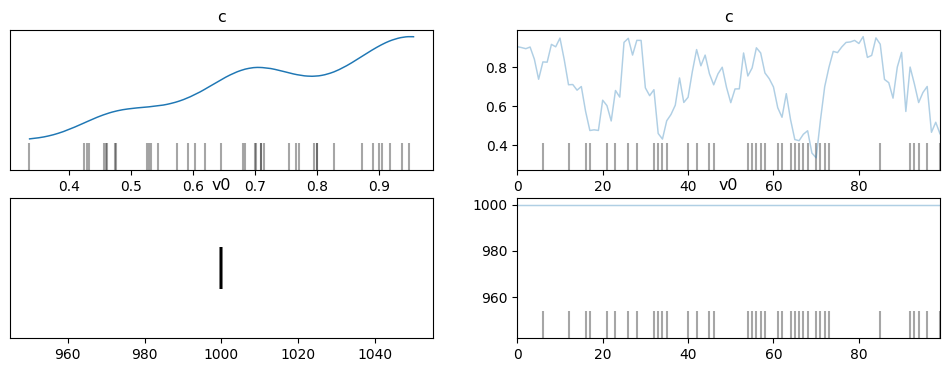

In [13]:
az.plot_trace(az_data)

/Users/rjersakova/Documents/Projects/autoemulate/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:826: RuntimeWarning: invalid value encountered in divide
  xyi /= [d_x, d_y]


ValueError: arange: cannot compute length

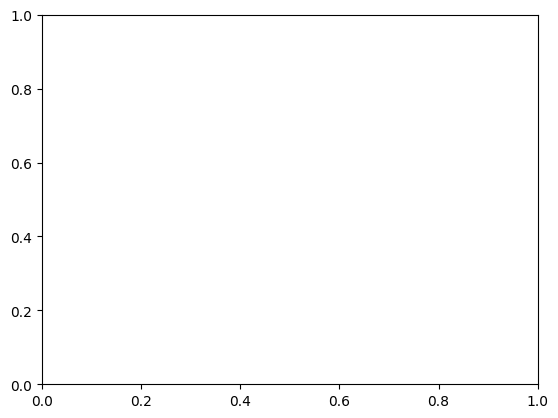

In [14]:
az.plot_pair(az_data, kind='kde')

array([<Axes: xlabel='distance'>, <Axes: xlabel='impact_velocity'>],
      dtype=object)

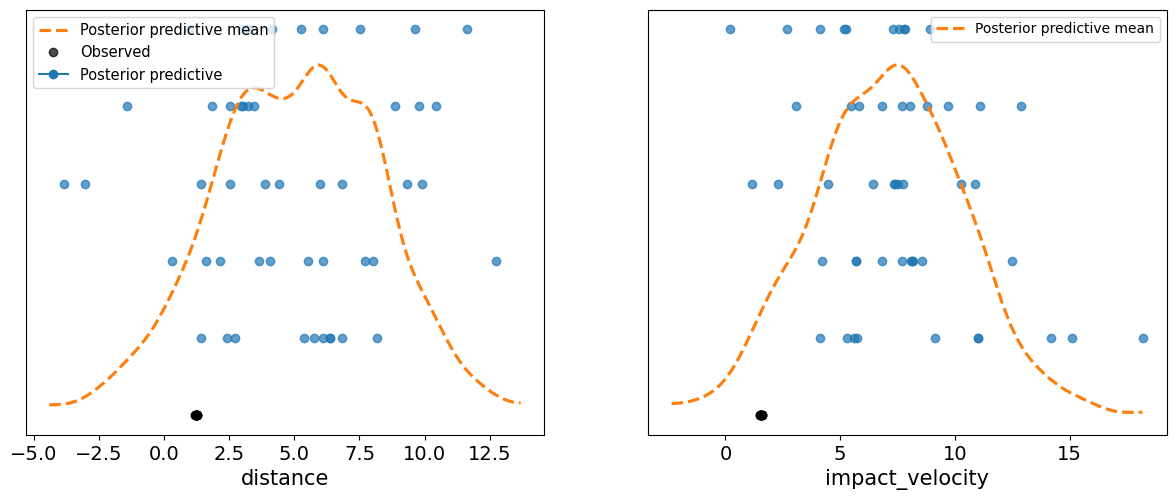

In [15]:
az.plot_ppc(az_data, kind='scatter')

## 3. Use sensitivity analysis and history matching to refine problem before running HMC.

The `HMCCalibrator` object has an option to provide a list of parameters to calibrate. A common approach is to select these based on results of `SensitivityAnalysis`.

Similarly, the user provides parameter ranges from withing which to sample parameter values. This can be simply the range of the simulator. Alternatively, one can use `HistoryMatching` to reduce the parameter range and pass that to the `HMCCalibrator` instead. 

Below we demonstrate how to do both.

In [ ]:
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis
from autoemulate.experimental.calibration.history_matching import HistoryMatching

1. Run sensitivity analysis and get top N parameters (here we just get the top 1).

In [ ]:
problem = {
        "num_vars": 2,
        "names": sim.param_names,
        "bounds": sim.param_bounds,
    }

sa = SensitivityAnalysis(gp, problem=problem)
df = sa.run("sobol")

top_param = sa.top_n_sobol_params(df, 1)

# the output is just a list of strings, this could be set by hand
top_param

2. Run history matching and generate new parameter bounds from NROY samples (if get any).

In [ ]:
# start with some GP predictions
x_new = sim.sample_inputs(20)
output = gp.predict(torch.tensor(x_new, dtype=torch.float32))
pred_means, pred_vars = (
    output.mean.float().detach(),
    output.variance.float().detach(),
)

In [ ]:
# generate NROY samples
hm = HistoryMatching(
    # take mean of observations and add noise
    observations={k: [v.mean(), 10.0] for k,v in observations.items()},
    threshold=5.0,
    rank=2
)
implausability = hm.calculate_implausibility(pred_means, pred_vars)
nroy_samples = hm.get_nroy(implausability, x_new)
nroy_samples

The newly generated range is slightly narrower than the range of the simulator.

In [ ]:
# get new param bounds
nroy_param_range = hm.generate_param_bounds(nroy_samples, param_names = sim.param_names)
nroy_param_range

3. Pass results to the HMCCalibrator object.

In [ ]:
hmc_nroy = HMCCalibrator(
    gp, 
    nroy_param_range if nroy_param_range is not None else sim.parameters_range, 
    observations, 
    10.0,
    top_param
    )

In [ ]:
mcmc_nroy = hmc_nroy.run(warmup_steps=10, num_samples=100)

In [ ]:
mcmc_nroy.summary()